In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.integrate import simps
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline

from modules import Sed

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

The trained N8 templates before spectral line reconstruction

![N8 Trained](plots/N8_trained.png)

I am going to try to reconstruct the spectral lines in N8_6, N8_7, and N_8.

In [3]:
original_templates = dict()
for i in range(1,9):
    name = 'N8_'+str(i)
    x,y = np.loadtxt('templates/'+name+'.sed',unpack=True)
    original_templates[name] = Sed(x,y)

Functions for spectral line reconstruction

In [4]:
def idx_closest(x,array):
    return np.fabs(np.array(array)-x).argmin()

def spectral_lines(sed,windows,FWHM=20,sig=None):
    
    if sig == None:
        sig = FWHM/2.355
    
    new_sed = copy.deepcopy(sed)
    
    integrals = []

    for window in windows:

        # get the area around the line(s)
        idx_lo = idx_closest(window[0],new_sed.wavelen)
        idx_hi = idx_closest(window[1],new_sed.wavelen)
        X = new_sed.wavelen[idx_lo:idx_hi+1].copy()
        Y = new_sed.flambda[idx_lo:idx_hi+1].copy()
        
        # subtract off the continuum
        continuum = np.interp(X,[X[0],X[-1]],[Y[0],Y[-1]])
        Y -= continuum
        
        # smooth the line flux and subtract from the sed
        spl = UnivariateSpline(X,Y)
        new_sed.flambda[idx_lo:idx_hi+1] -= spl(new_sed.wavelen[idx_lo:idx_hi+1])

        # calculate the flux from the line(s)
        integrals.append(simps(Y,X))
        
    # calculate the fluxes of all the lines
    Ha_scale = integrals[0]
    Hb_scale = 0.35*Ha_scale
    OIII_scale = integrals[1]-Hb_scale
    Hd_scale = 0.36*integrals[2]
    Hg_scale = 0.64*integrals[2]
    OII_scale = integrals[3]

    # calculate all the lines
    Ha = Ha_scale*norm.pdf(new_sed.wavelen,6563,sig)
    Hb = Hb_scale*norm.pdf(new_sed.wavelen,4861,sig)
    Hd = Hd_scale*norm.pdf(new_sed.wavelen,4102,sig)
    Hg = Hg_scale*norm.pdf(new_sed.wavelen,4340,sig)
    OII = OII_scale*norm.pdf(new_sed.wavelen,3727,sig)
    OIII = OIII_scale*norm.pdf(new_sed.wavelen,5007,sig)
    
    line_dict = dict()
    # save the relative strengths to Halpha
    line_dict['Halpha'] = {'ratio' : 1}
    line_dict['Hbeta'] = {'ratio' : Hb_scale/Ha_scale}
    line_dict['Hdelta'] = {'ratio' : Hd_scale/Ha_scale}
    line_dict['Hgamma'] = {'ratio' : Hg_scale/Ha_scale}
    line_dict['OII'] = {'ratio' : OII_scale/Ha_scale}
    line_dict['OIII'] = {'ratio' : OII_scale/Ha_scale}
    # save the equivalent widths
    continuum = np.clip(new_sed.flambda, a_min=1e-6, a_max=None)
    line_dict['Halpha']['eqW'] = simps(Ha/continuum,new_sed.wavelen)
    line_dict['Hbeta']['eqW'] = simps(Hb/continuum,new_sed.wavelen)
    line_dict['Hdelta']['eqW'] = simps(Hd/continuum,new_sed.wavelen)
    line_dict['Hgamma']['eqW'] = simps(Hg/continuum,new_sed.wavelen)
    line_dict['OII']['eqW'] = simps(OII/continuum,new_sed.wavelen)
    line_dict['OIII']['eqW'] = simps(OIII/continuum,new_sed.wavelen)
    
    # add the lines to the new sed
    new_sed.flambda += Ha + Hb + Hd + Hg + OII + OIII
    
    return new_sed, line_dict

Start with N8 8

         ratio      eqW
Halpha    1.00   132.69
Hbeta     0.35    32.96
Hdelta    0.23    19.75
Hgamma    0.41    36.24
OII       0.71    58.06
OIII      0.71    68.00


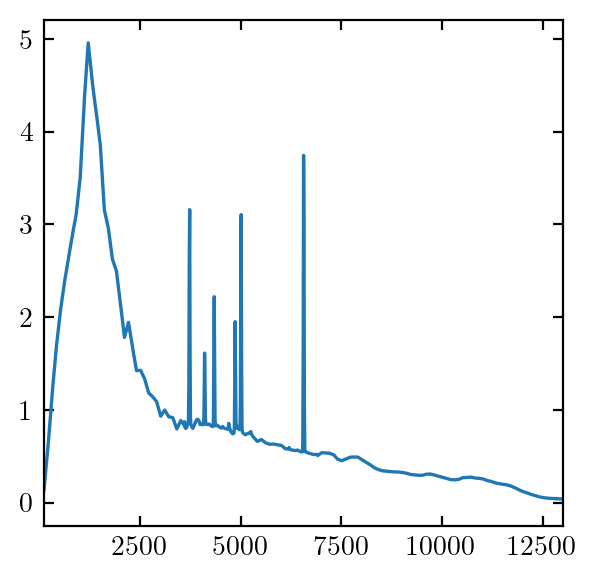

In [5]:
windows = [[6200,6900],[4700,5250],[4000,4550],[3600,4000]]
new8, line_dict = spectral_lines(original_templates["N8_8"],windows,FWHM=20)
plt.plot(new8.wavelen,new8.flambda)
plt.xlim(100,13000)
print("{:<8}{:>6}{:>9}".format('','ratio','eqW'))
for name,line in line_dict.items():
    ratio = line['ratio']
    eqW = line['eqW']
    print("{:<8}{:>6.2f}{:>9.2f}".format(name,ratio,eqW))

Now N8 7

         ratio      eqW
Halpha    1.00   103.29
Hbeta     0.35    26.42
Hdelta    0.26    16.91
Hgamma    0.45    31.39
OII       0.44    31.98
OIII      0.44    66.05


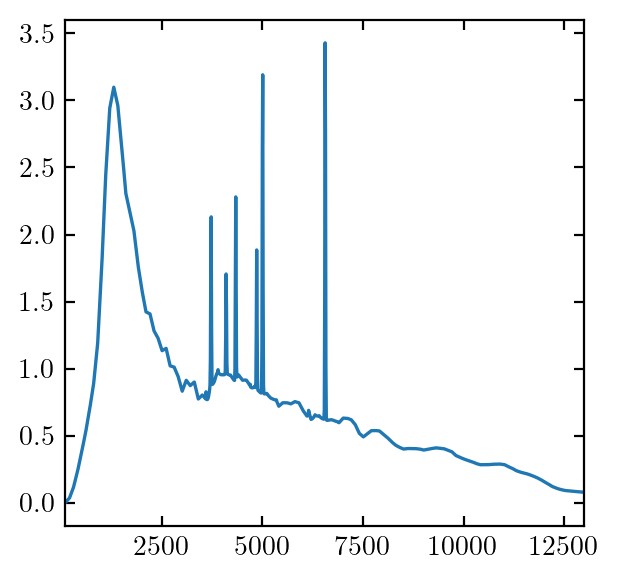

In [6]:
windows = [[6150,6900],[4700,5350],[3900,4600],[3600,3900]]
new7, line_dict = spectral_lines(original_templates["N8_7"],windows,FWHM=20)
plt.plot(new7.wavelen,new7.flambda)
plt.xlim(100,13000)
print("{:<8}{:>6}{:>9}".format('','ratio','eqW'))
for name,line in line_dict.items():
    ratio = line['ratio']
    eqW = line['eqW']
    print("{:<8}{:>6.2f}{:>9.2f}".format(name,ratio,eqW))

Now N8 6

         ratio      eqW
Halpha    1.00   115.19
Hbeta     0.35    30.29
Hdelta    0.25    20.96
Hgamma    0.45    36.87
OII       0.26    24.35
OIII      0.26    27.31


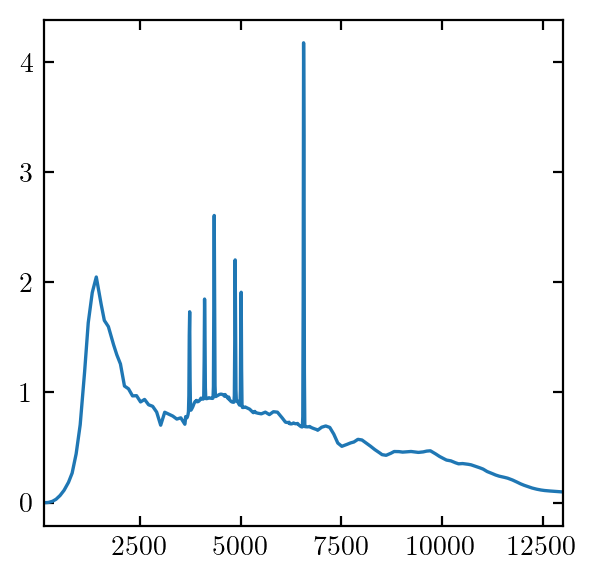

In [7]:
windows = [[6200,6900],[4700,5350],[3900,4600],[3630,3900]]
new6, line_dict = spectral_lines(original_templates["N8_6"],windows,FWHM=20)
plt.plot(new6.wavelen,new6.flambda)
plt.xlim(100,13000)
print("{:<8}{:>6}{:>9}".format('','ratio','eqW'))
for name,line in line_dict.items():
    ratio = line['ratio']
    eqW = line['eqW']
    print("{:<8}{:>6.2f}{:>9.2f}".format(name,ratio,eqW))

Make a plot of the three new templates

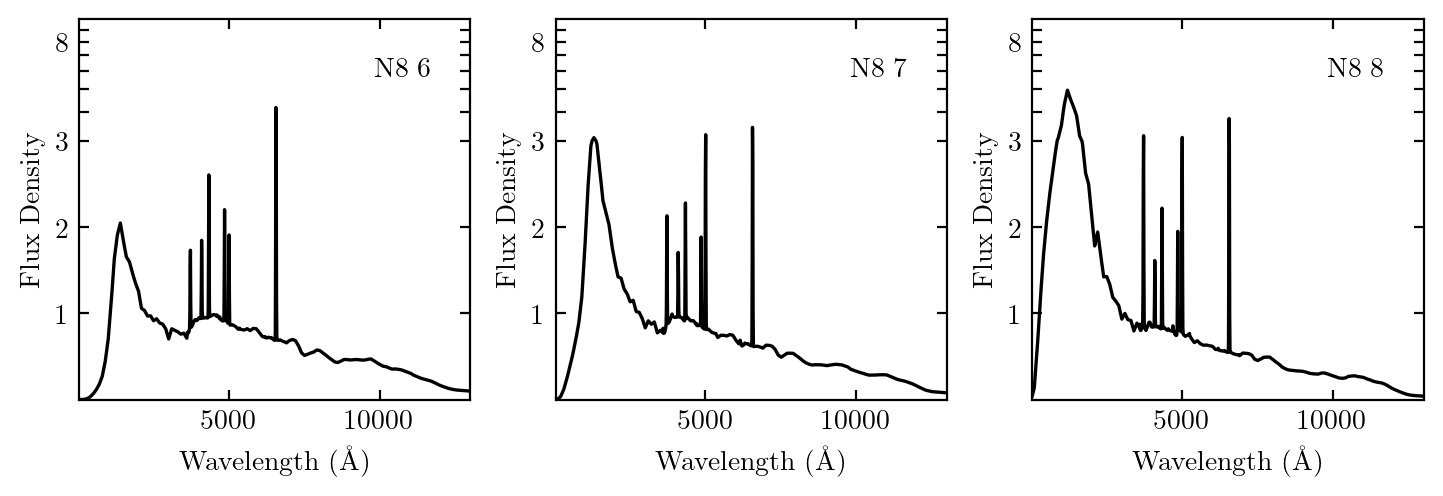

In [8]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(twocol,twocol/3),constrained_layout=True)

ax1.plot(new6.wavelen,new6.flambda,c='k')
ax2.plot(new7.wavelen,new7.flambda,c='k')
ax3.plot(new8.wavelen,new8.flambda,c='k')

for i,ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.9,0.9,"N8 "+str(i+6),transform=ax.transAxes,ha="right",va="top")
    ax.set_xlim(50,13000)
    ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','',8,''])
    ax.set_ylabel('Flux Density')
    
fig.savefig('plots/N8_spectral_lines.pdf')

Save the 3 new templates

In [9]:
templates = [new6,new7,new8]
names = ['N8_6_speclines','N8_7_speclines','N8_8_speclines']

for template,name in zip(templates,names):
    file = open('templates/'+name+'.sed','w')
    for i in range(len(template.wavelen)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(template.wavelen[i],template.flambda[i]))
    file.close()

Here is the code I used to figure out what windows I want to use. Saving it here in case I want to use it again in the future

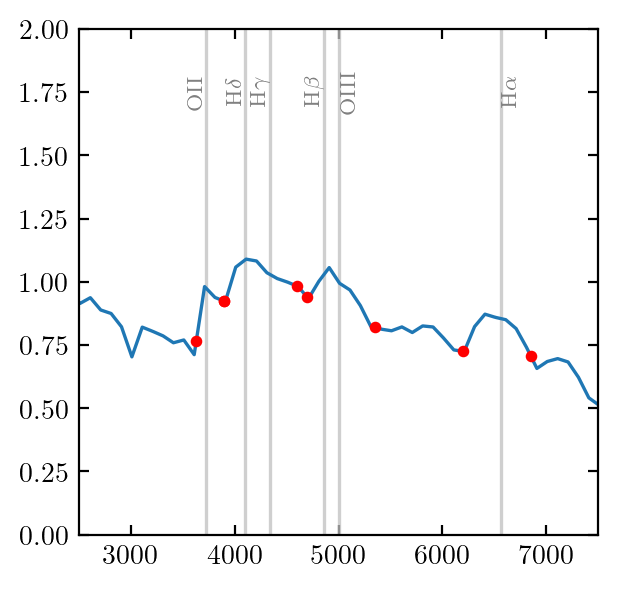

In [10]:
template = copy.deepcopy(original_templates['N8_6'])

plt.plot(template.wavelen,template.flambda)

box_style = dict(facecolor='none', edgecolor='none', pad=0)
# Halpha
plt.vlines(6563,0,10,color='silver',alpha=0.75) # Halpha
plt.text(6563,1.75,r"H$\alpha$",fontsize=8,rotation=90,
         color='gray',ha='left',va='center',bbox=box_style)
# Hbeta   
plt.vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
plt.text(4861,1.75,r"H$\beta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center')       
# OIII
plt.vlines(5007,0,10,color='silver',alpha=0.75) # OIII
plt.text(5007,1.75,"OIII",fontsize=8,rotation=90,
         color='gray',ha='left',va='center')
# OII
plt.vlines(3727,0,10,color='silver',alpha=0.75) # OII
plt.text(3727,1.75,"OII",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hdelta
plt.vlines(4102,0,2.1,color='silver',alpha=0.75) # Hdelta
plt.text(4102,1.75,r"H$\delta$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)
# Hgamma
plt.vlines(4340,0,2.1,color='silver',alpha=0.75) # Hgamma
plt.text(4340,1.75,r"H$\gamma$",fontsize=8,rotation=90,
         color='gray',ha='right',va='center',bbox=box_style)

plt.ylim(0,2)
plt.xlim(2500,7500)

points = [6200,6850,4700,5350,3900,4600,3630,3900]

for point in points:
    idx = idx_closest(point,template.wavelen)
    plt.scatter(template.wavelen[idx],template.flambda[idx],c='r',s=10,zorder=10)